In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
import time
import itertools

In [2]:
df = pd.read_csv("Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
loads = np.asarray(df["crawfordCrescent_F2"])

In [3]:
h = 48
d = 161

rates = pd.read_csv("agile_rates_2019.csv")
buyPrice = rates["unit_rate_incl_vat"].iloc[d*h:d*h+h]
priceDict = dict(enumerate(buyPrice))

In [4]:
class Battery:
    def __init__(self, maxSOC, maxChargeRate, maxDischargeRate, chargeEfficiency, dischargeEfficiency):
        self.maxSOC = maxSOC
        self.maxChargeRate = maxChargeRate
        self.maxDischargeRate = maxDischargeRate
        self.chargeEfficiency = chargeEfficiency
        self.dischargeEfficiency = dischargeEfficiency



day = loads[d*h:d*h+h]
peakLoad = max(loads)



SOC = max(loads)*0.25
D = max(loads)*0.25
C = D/2
efficiency = 0.95


batt = Battery(SOC, C, D, efficiency, efficiency)

In [5]:
loadDict = dict(enumerate(day))

In [6]:
# Initialise model
m = ConcreteModel()

# Create time to be used as index
m.Time = RangeSet(0, h-1)

In [7]:
# Declare Decision variables
m.SOC = Var(m.Time, bounds=(0,batt.maxSOC), initialize=0) # State of Charge variable, cant be greater than max SOC
m.posDeltaSOC = Var(m.Time, initialize=0) # Change of State of Charge
m.negDeltaSOC = Var(m.Time, initialize=0)
#m.posEtoBatt = Var(m.Time, bounds=(0,batt.maxChargeRate*(30/60)), initialize=0) # Energy in grid, converted to Watts
#m.negEfromBatt = Var(m.Time, bounds=(0,batt.maxDischargeRate*(30/60)), initialize=0)
m.netLoad = Var(m.Time, initialize=loadDict) # Net load from grid




In [8]:
# Boolean variables, used to determine wether battery is charging or discharging
m.Bool_char = Var(m.Time, within=Boolean) # 1 if battery is charging
m.Bool_dis = Var(m.Time, within=Boolean, initialize=0) # 1 if battery is discharging


In [9]:
m.dayLoads = Param(m.Time, initialize=loadDict)
m.priceBuy = Param(m.Time, initialize=priceDict)

In [10]:
#m.chargeEfficiency = Param(initialize=batt.chargeEfficiency)
#m.dischargeEfficiency = Param(initialize=batt.dischargeEfficiency)
m.chargingLimit = Param(initialize=batt.maxChargeRate*(30/60))
m.dischargingLimit = Param(initialize=batt.maxDischargeRate*(30/60))

In [11]:
# Constraints
# SOC is equal to SOC at previous time plus change in SOC
def SOC_rule(m,t):
    if t==0:
        return(m.SOC[t] == m.posDeltaSOC[t] + m.negDeltaSOC[t])
    else:
        return(m.SOC[t] == m.SOC[t-1] + m.posDeltaSOC[t] + m.negDeltaSOC[t])
m.Batt_SOC = Constraint(m.Time, rule=SOC_rule)

In [12]:
def charging_rule(m,t):
    return m.posDeltaSOC[t] <= m.chargingLimit
m.charging_rule = Constraint(m.Time, rule=charging_rule)

def discharging_rule(m,t):
    return m.negDeltaSOC <= m.dischargingLimit
m.charging_rule = Constraint(m.Time, rule=charging_rule)

def demand_rule(m,t):
    return m.negDeltaSOC[t] - m.posDeltaSOC[t] + m.netLoad[t] == m.dayLoads[t]
m.demand_rule = Constraint(m.Time, rule=demand_rule)

    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>) on block
    unknown with a new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


In [13]:
def Bool_char_rule_1(m,t):
    bigM = 500000
    return(m.posDeltaSOC[t] >= -bigM*(m.Bool_char[t]))
m.Batt_char1 = Constraint(m.Time, rule=Bool_char_rule_1)

def Bool_char_rule_2(m,t):
    bigM = 500000
    return(m.posDeltaSOC[t] <= 0+bigM*(1 - m.Bool_dis[t]))
m.Batt_char2 = Constraint(m.Time, rule=Bool_char_rule_2)

def Bool_char_rule_3(m,i):
    bigM = 500000
    return((m.negDeltaSOC[i]) <= bigM*(m.Bool_dis[i]))
m.Batt_cd3 = Constraint(m.Time,rule=Bool_char_rule_3)

def Bool_char_rule_4(m,i):
    bigM=500000
    return((m.negDeltaSOC[i]) >= 0-bigM*(1-m.Bool_char[i]))
m.Batt_cd4 = Constraint(m.Time,rule=Bool_char_rule_4)

def Bool_char_dis(m,t):
    return(m.Bool_char[t] + m.Bool_dis[t], 1)
m.Batt_char_dis = Constraint(m.Time, rule=Bool_char_dis)

In [14]:
# # Account for charging efficiency
# def pos_E_in_rule(m,t):
#     return m.posEtoBatt[t] == m.posDeltaSOC[t]/m.chargeEfficiency
# m.posEIn_cons = Constraint(m.Time, rule=pos_E_in_rule)

# # Account for discharging efficiency
# def neg_E_out_rule(m,t):
#     return m.negEfromBatt[t] == m.negDeltaSOC[t]*m.dischargeEfficiency
# m.negEOut_cons = Constraint(m.Time, rule=neg_E_out_rule)

In [15]:
# # ensure charging rate obeyed
# def E_charging_rate_rule(m,t):
#     return m.posEtoBatt[t] <= m.chargingLimit
# m.chargingLimit_cons = Constraint(m.Time, rule=E_charging_rate_rule)

# # ensure DIScharging rate obeyed
# def E_discharging_rate_rule(m,t):
#     return m.negEfromBatt[t] >= m.dischargingLimit
# m.dischargingLimit_cons = Constraint(m.Time, rule=E_discharging_rate_rule)

In [16]:
# # calculate the net demand
# def E_net_rule(m,t):
#     return m.netLoad[t] == m.dayLoads[t] + m.posEtoBatt[t] + m.negEfromBatt[t]
# m.E_posNet_cons = Constraint(m.Time, rule=E_net_rule)

In [17]:
# D = {}
# m.k = list(itertools.product)

# m.is_max = Var(m.Time, within=Boolean)
# m.maxLoad = Var(m.Time, within=NonNegativeReals) # Stores max load value

# def is_max_1(m,t):
#     return sum(m.is_max[j] for j in m.Time) == 1
# m.is_max_1 = Constraint(m.Time, rule=is_max_1)

# def is_max_const(m,t):
#     bigM = 500000
#     return m.maxLoad[t] <= bigM * m.is_max[t]
# m.is_max_const = Constraint(m.Time, rule=is_max_const)

In [18]:
# def is_max(m,t):
#     return m.maxLoad >= m.netLoad[t]
# m.is_max = Constraint(m.Time, rule=is_max)
 

In [19]:
# Objective function is max of loads in the day
def Obj_func(m):
    return sum(m.priceBuy[i]*m.netLoad[i] for i in m.Time)
m.max_load = Objective(rule=Obj_func, sense=minimize)

In [20]:
opt = SolverFactory("glpk", executable="D:\\glpk-4.65\\w64\\glpsol")

In [21]:
t = time.time()
results = opt.solve(m)
elapsed = time.time() - t
print ('Time elapsed:', elapsed)

In [ ]:
j = 0
for v in m.component_objects(Var, active=True):
    print (j, v.getname())
    j+=1

0 SOC
1 posDeltaSOC
2 negDeltaSOC
3 netLoad
4 Bool_char
5 Bool_dis


In [ ]:
outputVars = np.zeros((9,len(day)))

In [ ]:
j = 0
for v in m.component_objects(Var, active=True):
    print (v.getname())
    #print varobject.get_values()
    varobject = getattr(m, str(v))
    for index in varobject:
        outputVars[j,index] = varobject[index].value
    j+=1
    if j>=9:
        break


SOC
posDeltaSOC
negDeltaSOC
netLoad
Bool_char
Bool_dis


<bound method Figure.show of <Figure size 1080x576 with 2 Axes>>

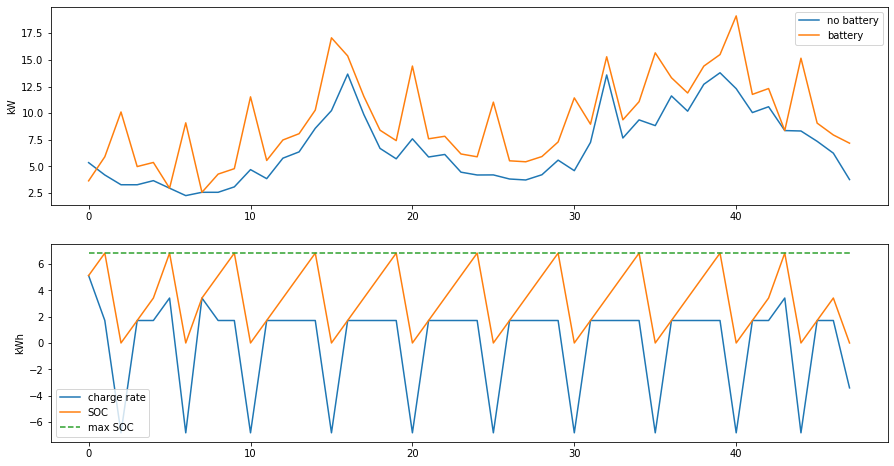

In [ ]:
newLoad = outputVars[3]
SOC = outputVars[0]
chargeRate = outputVars[1] + outputVars[2]
maxSOC = np.ones(48) * batt.maxSOC

y = list(range(48))
fig, axs = plt.subplots(2)
axs[0].plot(y,day, label="no battery")
axs[0].plot(y,newLoad, label="battery")
axs[0].legend()
axs[0].set_ylabel("kW")

axs[1].plot(y,chargeRate, label="charge rate")
axs[1].plot(y,SOC,label="SOC")
axs[1].plot(y,maxSOC, label="max SOC", linestyle="dashed")
axs[1].legend()
axs[1].set_ylabel("kWh")


fig.set_figheight(8)
fig.set_figwidth(15)
fig.show